In [ ]:
# SCRIPT: ATTENTION HEAD SYNTACTIC ALIGNMEN

# ENVIRONMENT SETUP (Includes Visualization Libraries)
print("─" * 80)
print("PHASE 0: SETTING UP THE ENVIRONMENT...")
print("─" * 80)

import subprocess
import sys

def install(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    install("transformers")
    install("datasets")
    install("accelerate")
    install("stanza")
    install("numpy")
    install("pandas")
    install("matplotlib")
    install("seaborn")
    import stanza
    print("\nDownloading Stanza English model...")
    stanza.download('en', verbose=False)
    print("Stanza model downloaded successfully!")
except Exception as e:
    print(f"An error occurred during installation or download: {e}")

print("\nImporting libraries...")
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast, BertModel
from datasets import load_dataset
import warnings
from tqdm.notebook import tqdm # For a nice progress bar

warnings.filterwarnings("ignore", category=FutureWarning)
print("Environment setup complete.\n")

# DATA ACQUISITION & MODEL LOADING (From previous step)
print("─" * 80)
print("LOADING MODEL, DATASET, AND PARSER...")
print("─" * 80)

MODEL_NAME = 'bert-base-uncased'
DATASET_NAME = 'glue'
DATASET_CONFIG = 'mnli'
SAMPLE_SIZE = 9815 # Using 100 samples for a quicker run. Increase for more robust results.

print("Initializing Stanza NLP pipeline...")
nlp_pipeline = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse', verbose=False)
print("Stanza pipeline ready.")

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Model loaded and moved to device: {device}")

dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"validation_matched[:{SAMPLE_SIZE}]")
print(f"Dataset loaded with {len(dataset)} sentences.")

────────────────────────────────────────────────────────────────────────────────
PHASE 0: SETTING UP THE ENVIRONMENT...
────────────────────────────────────────────────────────────────────────────────
Installing transformers...
Installing datasets...
Installing accelerate...
Installing stanza...
Installing numpy...
Installing pandas...
Installing matplotlib...
Installing seaborn...

Stanza model downloaded successfully!

Importing libraries...
Environment setup complete.

────────────────────────────────────────────────────────────────────────────────
LOADING MODEL, DATASET, AND PARSER...
────────────────────────────────────────────────────────────────────────────────
Initializing Stanza NLP pipeline...
Stanza pipeline ready.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model loaded and moved to device: cuda


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset loaded with 9815 sentences.


In [ ]:
#METRIC IMPLEMENTATION & ANALYSIS
print("\n" + "─" * 80)
print("IMPLEMENTING METRICS AND RUNNING ANALYSIS...")
print("─" * 80)

def create_offset_based_map(sentence_text, tokenizer, stanza_doc):
    stanza_word_offsets = []
    original_words = []
    for sentence in stanza_doc.sentences:
        for word in sentence.words:
            original_words.append(word.text)
            stanza_word_offsets.append((word.start_char, word.end_char))

    encoding = tokenizer(sentence_text, return_offsets_mapping=True, return_tensors="pt")
    bert_token_offsets = encoding['offset_mapping'][0]

    token_to_word_map = []
    for token_start, token_end in bert_token_offsets:
        if token_start == 0 and token_end == 0:
            token_to_word_map.append(-1)
            continue
        found = False
        for word_idx, (word_start, word_end) in enumerate(stanza_word_offsets):
            if token_start >= word_start and token_end <= word_end:
                token_to_word_map.append(word_idx)
                found = True
                break
        if not found:
            token_to_word_map.append(-1)

    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    return token_to_word_map, tokens, original_words, encoding

def extract_gold_dependency_pairs_from_stanza(doc):
    gold_pairs = set()
    offset = 0
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.head > 0:
                head_index = word.head - 1 + offset
                dependent_index = word.id - 1 + offset
                # Store as an undirected, sorted tuple for easy comparison
                gold_pairs.add(tuple(sorted((head_index, dependent_index))))
        offset += len(sentence.words)
    return gold_pairs

# --- UUAS Calculation Function ---

def calculate_uuas_for_head(attention_matrix, token_to_word_map, gold_pairs):
    """
    Calculates the UUAS for a single head on a single sentence.
    The score is the proportion of words whose maximum attention correctly
    points to its syntactic head.
    """
    if not gold_pairs:
        return 0.0, 0

    correct_predictions = 0
    total_words = 0

    num_tokens = len(token_to_word_map)
    # Get a list of unique word indices, ignoring special tokens (-1)
    word_indices = sorted(list(set(idx for idx in token_to_word_map if idx != -1)))

    for word_idx in word_indices:
        total_words += 1

        # Find all tokens that correspond to the current word
        source_token_indices = [i for i, w_idx in enumerate(token_to_word_map) if w_idx == word_idx]

        # Aggregate attention from all source tokens of the word
        # We take the mean attention from all sub-words of a word
        aggregated_attention = attention_matrix[source_token_indices, :].mean(axis=0)

        # Find the token that receives the maximum attention
        # We ignore attention to self and to special tokens like [CLS] and [SEP]
        valid_targets_mask = np.array([1 if token_to_word_map[i] not in [-1, word_idx] else 0 for i in range(num_tokens)])
        if np.sum(valid_targets_mask) == 0:
            continue # No valid targets to attend to

        max_attention_idx = np.argmax(aggregated_attention * valid_targets_mask)
        predicted_head_word_idx = token_to_word_map[max_attention_idx]

        # Form the predicted dependency pair (undirected)
        predicted_pair = tuple(sorted((word_idx, predicted_head_word_idx)))

        # Check if the predicted pair is in our set of gold standard pairs
        if predicted_pair in gold_pairs:
            correct_predictions += 1

    # The UUAS for this sentence is the ratio of correct predictions
    uuas = correct_predictions / total_words if total_words > 0 else 0.0
    return uuas, total_words



────────────────────────────────────────────────────────────────────────────────
IMPLEMENTING METRICS AND RUNNING ANALYSIS...
────────────────────────────────────────────────────────────────────────────────


In [ ]:
# DEMONSTRATION OF PHASES 0 & 1
# This section demonstrates that all setup and helper functions are working
# correctly by running them on a single example from our dataset.
if __name__ == "__main__":
    if nlp_pipeline is not None and len(dataset) > 0:
        print("─" * 80)
        print("DEMONSTRATION: Running setup on a sample sentence")
        print("─" * 80)

        sample_index = 5
        sample_entry = dataset[sample_index]
        sentence_text = sample_entry['premise']

        print(f"Original Sentence Text: '{sentence_text}'\n")

        # 1. Use Stanza to parse the document
        doc = nlp_pipeline(sentence_text)

        # 2. Create the robust, offset-based alignment map
        print("1. Creating robust alignment map using character offsets:")
        token_map, tokens, original_words = create_offset_based_map(sentence_text, tokenizer, doc)

        print(f"\n   Stanza Words: {original_words}")
        print(f"   BERT Tokens: {tokens}")
        print(f"   Alignment Map (Token Idx -> Word Idx): {token_map}")

        # 3. Extract gold dependencies
        gold_dependencies = extract_gold_dependency_pairs_from_stanza(doc)
        print(f"\n   Extracted {len(gold_dependencies)} dependency pairs from Stanza.")

        print("\n2. Verification of Alignment (This will now succeed):")


        print(f"   Tokens: {tokens}")
        print(f"   Alignment Map (Token Idx -> Word Idx): {token_map}")

        print("\n   Verification of Alignment:")
        for token_idx, word_idx in enumerate(token_map):
            if word_idx != -1:
                print(f"      - Token '{tokens[token_idx]}' maps to Word '{original_words[word_idx]}'")

        print("\n\nDemonstration complete. The environment is now correctly set up.")
    else:
        print("Setup failed. Cannot run demonstration.")

────────────────────────────────────────────────────────────────────────────────
DEMONSTRATION: Running setup on a sample sentence
────────────────────────────────────────────────────────────────────────────────
Original Sentence Text: 'well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be'

1. Creating robust alignment map using character offsets:

   Stanza Words: ['well', 'that', 'would', 'be', 'a', 'help', 'i', 'wish', 'they', 'would', 'do', 'that', 'here', 'we', 'have', 'got', 'so', 'little', 'landfill', 'space', 'left', 'that', 'we', "'re", 'going', 'to', 'run', 'out', 'before', 'the', 'end', 'of', 'this', 'decade', 'and', 'it', "'s", 'really', 'going', 'to', 'be']
   BERT Tokens: ['[CLS]', 'well', 'that', 'would', 'be', 'a', 'help', 'i', 'wish', 'they', 'would', 'do', 'that', 'here', 'we', 'have', 'got', 'so', 'little', 'landfill', 'space', 'left', '

Starting analysis loop...


Analyzing Sentences:   0%|          | 0/9815 [00:00<?, ?it/s]

Analysis loop finished.

────────────────────────────────────────────────────────────────────────────────
Top 10 Most Syntactic Heads (by Average UUAS)
────────────────────────────────────────────────────────────────────────────────
 Layer  Head   UUAS
     7    10 0.6028
     6     5 0.5804
     8     5 0.5206
     3    10 0.5021
     5     7 0.5011
     3     9 0.5003
     4     5 0.4937
     7     6 0.4634
     4     7 0.4398
     5     0 0.4374

────────────────────────────────────────────────────────────────────────────────
Generating UUAS Heatmap...
────────────────────────────────────────────────────────────────────────────────


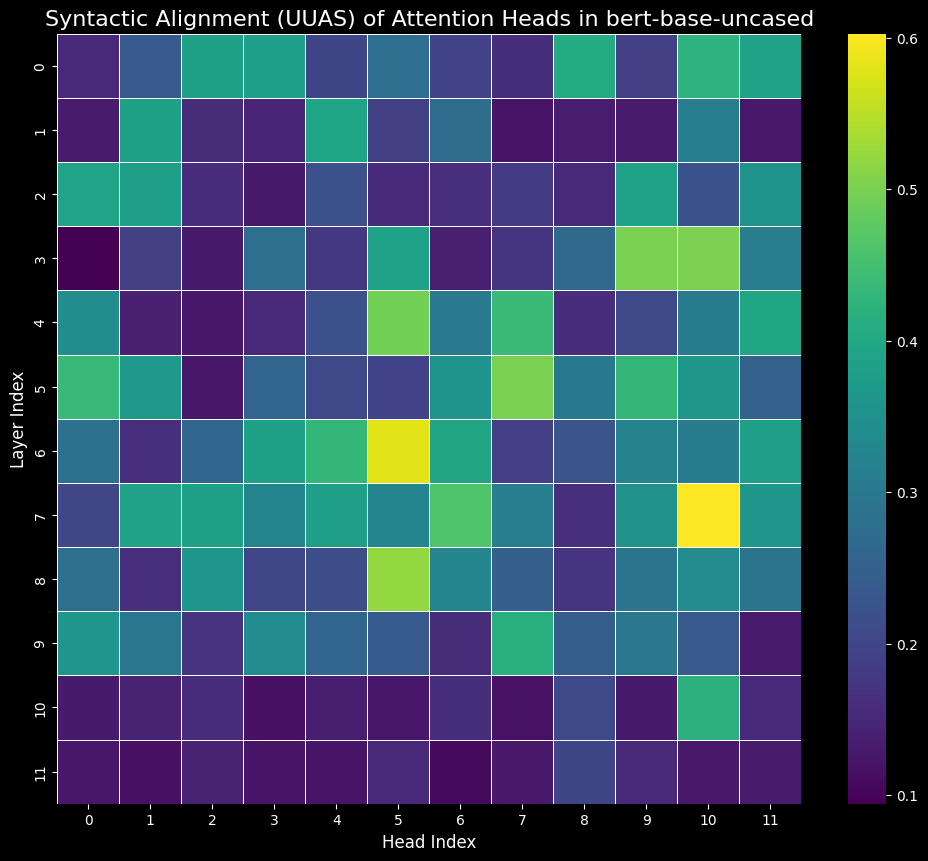


Baseline Analysis Complete.


In [ ]:
# --- Main Analysis Loop ---

# Dictionary to store scores: (layer, head) -> [list of scores per sentence]
head_scores = {
    (l, h): [] for l in range(model.config.num_hidden_layers) for h in range(model.config.num_attention_heads)
}

print("Starting analysis loop...")
for example in tqdm(dataset, desc="Analyzing Sentences"):
    sentence_text = example['premise']
    if not sentence_text:
        continue

    # 1. Get Gold Standard Data from Stanza
    doc = nlp_pipeline(sentence_text)
    gold_dependencies = extract_gold_dependency_pairs_from_stanza(doc)

    # 2. Get Model Attention and Alignment Map
    token_to_word_map, tokens, original_words, encoding = create_offset_based_map(sentence_text, tokenizer, doc)

    # The tokenizer's encoding object includes 'offset_mapping', which the model doesn't accept.
    # We create a new dictionary containing only the valid model inputs.
    model_inputs = {
        'input_ids': encoding['input_ids'].to(device),
        'token_type_ids': encoding['token_type_ids'].to(device),
        'attention_mask': encoding['attention_mask'].to(device)
    }

    with torch.no_grad():
        outputs = model(**model_inputs)

    attentions = outputs.attentions # This is a tuple of (num_layers) tensors

    # 3. Calculate UUAS for every layer and head
    for layer_idx in range(model.config.num_hidden_layers):
        for head_idx in range(model.config.num_attention_heads):
            # Extract attention matrix for the current head and move to CPU
            attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

            uuas, num_words = calculate_uuas_for_head(attention_matrix, token_to_word_map, gold_dependencies)

            if num_words > 0:
                head_scores[(layer_idx, head_idx)].append(uuas)

print("Analysis loop finished.")
# --- Aggregate and Visualize Results ---

results_data = []
for (layer, head), scores in head_scores.items():
    avg_score = np.mean(scores) if scores else 0
    results_data.append({"Layer": layer, "Head": head, "UUAS": avg_score})

results_df = pd.DataFrame(results_data)

# Print the top 10 heads
print("\n" + "─" * 80)
print("Top 10 Most Syntactic Heads (by Average UUAS)")
print("─" * 80)
print(results_df.sort_values(by="UUAS", ascending=False).head(10).to_string(index=False, float_format="%.4f"))

# Create the heatmap
print("\n" + "─" * 80)
print("Generating UUAS Heatmap...")
print("─" * 80)
plt.style.use('dark_background')
# Pivot the DataFrame to create a matrix for the heatmap
heatmap_data = results_df.pivot(index="Layer", columns="Head", values="UUAS")

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="viridis", linewidths=.5)
plt.title(f"Syntactic Alignment (UUAS) of Attention Heads in {MODEL_NAME}", fontsize=16)
plt.xlabel("Head Index", fontsize=12)
plt.ylabel("Layer Index", fontsize=12)
plt.show()

print("\nBaseline Analysis Complete.")

In [ ]:
# --- Add these lines at the end of your script ---

# 1. Import the 'files' module from google.colab to handle downloads
from google.colab import files

# 2. Define a descriptive filename for your pre-trained model results
output_filename = "pretrained_bert_uuas_scores.csv"

# 3. Save the DataFrame to a CSV file in the Colab environment's storage
print(f"\nSaving UUAS scores to '{output_filename}'...")
results_df.to_csv(output_filename, index=False, float_format="%.4f")

# 4. Trigger the browser to download the file from Colab to your local machine
files.download(output_filename)

print(f"Successfully downloaded {output_filename}.")


Saving UUAS scores to 'pretrained_bert_uuas_scores.csv'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded pretrained_bert_uuas_scores.csv.


In [ ]:
# This code cell fine-tunes the `bert-base-uncased` model on the Multi-Genre
# Natural Language Inference (MNLI) task. It uses the Hugging Face Trainer API
# for a straightforward and powerful training loop.

# ENVIRONMENT SETUP
print("─" * 80)
print("SETTING UP THE ENVIRONMENT FOR FINE-TUNING...")
print("─" * 80)

import subprocess
import sys

def install(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    install("transformers")
    install("datasets")
    install("accelerate")
    # 'evaluate' is the new library for metrics, replacing `datasets.load_metric`
    install("evaluate")
    install("numpy")
except Exception as e:
    print(f"An error occurred during installation: {e}")

print("\nImporting libraries...")
import torch
import numpy as np
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import warnings
import os

warnings.filterwarnings("ignore", category=FutureWarning)
print("Environment setup complete.\n")

# FINE-TUNING AND COMPARATIVE ANALYSIS
print("─" * 80)
print("PHASE 2: FINE-TUNING ON NATURAL LANGUAGE INFERENCE (NLI)...")
print("─" * 80)

# --- Configuration ---
MODEL_NAME = "bert-base-uncased"
TASK_NAME = "mnli"
# This directory will be created in your Colab environment to save the model
OUTPUT_DIR = "./mnli_finetuned_model"
# For a quick but effective fine-tuning, 1-2 epochs are sufficient. 3 is standard for full training.
TRAINING_EPOCHS = 3
BATCH_SIZE = 16
TRAIN_SAMPLE_SIZE = 8000
EVAL_SAMPLE_SIZE = 1000

# --- Data Preprocessing Function ---
def tokenize_function(examples, tokenizer):
    """Tokenizes the premise and hypothesis text for the NLI task."""
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length", # Pad to a uniform length
        max_length=128      # A reasonable max length for NLI sentences
    )

# --- Metrics Calculation Function ---
def compute_metrics(eval_pred):
    """Computes accuracy during evaluation."""
    metric = evaluate.load("glue", TASK_NAME)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# --- Main Fine-Tuning Execution ---

# 1. Load Model, Tokenizer, and Data
print("Loading model, tokenizer, and dataset...")
# Use `AutoModelForSequenceClassification` which includes a classification head.
# `num_labels=3` for the three NLI classes: entailment, neutral, contradiction.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
raw_datasets = load_dataset("glue", TASK_NAME)

# 2. Select subsets and tokenize the data
print(f"Preparing and tokenizing {TRAIN_SAMPLE_SIZE} training and {EVAL_SAMPLE_SIZE} evaluation samples...")
train_dataset = raw_datasets["train"].shuffle(seed=42).select(range(TRAIN_SAMPLE_SIZE))
eval_dataset = raw_datasets["validation_matched"].shuffle(seed=42).select(range(EVAL_SAMPLE_SIZE))

tokenized_train_dataset = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
tokenized_eval_dataset = eval_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

# 3. Configure Training Arguments
# These arguments control the entire training process.
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=TRAINING_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",      # Evaluate at the end of each epoch
    save_strategy="epoch",      # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,# Load the best model found during training
    report_to="none",           # Disable reporting to services like wandb
)

# 4. Initialize and Run the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

print(f"\nStarting fine-tuning for {TRAINING_EPOCHS} epoch(s)...")
# This command starts the training loop. It will take several minutes on a Colab GPU.
trainer.train()

# 5. Save the final best model
# This path is what you will use in the next analysis step.
final_model_path = os.path.join(OUTPUT_DIR, "final_best_model")
trainer.save_model(final_model_path)
print(f"\nFine-tuning complete. Best model saved to: {final_model_path}")

────────────────────────────────────────────────────────────────────────────────
SETTING UP THE ENVIRONMENT FOR FINE-TUNING...
────────────────────────────────────────────────────────────────────────────────
Installing transformers...
Installing datasets...
Installing accelerate...
Installing evaluate...
Installing numpy...

Importing libraries...
Environment setup complete.

────────────────────────────────────────────────────────────────────────────────
PHASE 2: FINE-TUNING ON NATURAL LANGUAGE INFERENCE (NLI)...
────────────────────────────────────────────────────────────────────────────────
Loading model, tokenizer, and dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing and tokenizing 8000 training and 1000 evaluation samples...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


Starting fine-tuning for 3 epoch(s)...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.804400,0.830701,0.643000
2,0.560500,0.703055,0.719000
3,0.208700,0.955816,0.720000



Fine-tuning complete. Best model saved to: ./mnli_finetuned_model/final_best_model


Initializing Stanza NLP pipeline...
Stanza pipeline ready.
Model loaded from './mnli_finetuned_model/final_best_model' and moved to device: cuda
Dataset loaded with 9815 sentences.

────────────────────────────────────────────────────────────────────────────────
IMPLEMENTING METRICS AND RUNNING ANALYSIS ON FINE-TUNED MODEL...
────────────────────────────────────────────────────────────────────────────────
Starting analysis loop...


Analyzing Sentences:   0%|          | 0/9815 [00:00<?, ?it/s]

Analysis loop finished.

────────────────────────────────────────────────────────────────────────────────
Top 10 Most Syntactic Heads in FINE-TUNED Model (by Average UUAS)
────────────────────────────────────────────────────────────────────────────────
 Layer  Head   UUAS
     7    10 0.6413
     6     5 0.6003
     8     5 0.5275
     4     5 0.5253
     3    10 0.5128
     3     9 0.5120
     5     7 0.5114
     7     6 0.4953
     5     0 0.4621
     4     7 0.4474

────────────────────────────────────────────────────────────────────────────────
Generating UUAS Heatmap for FINE-TUNED Model...
────────────────────────────────────────────────────────────────────────────────


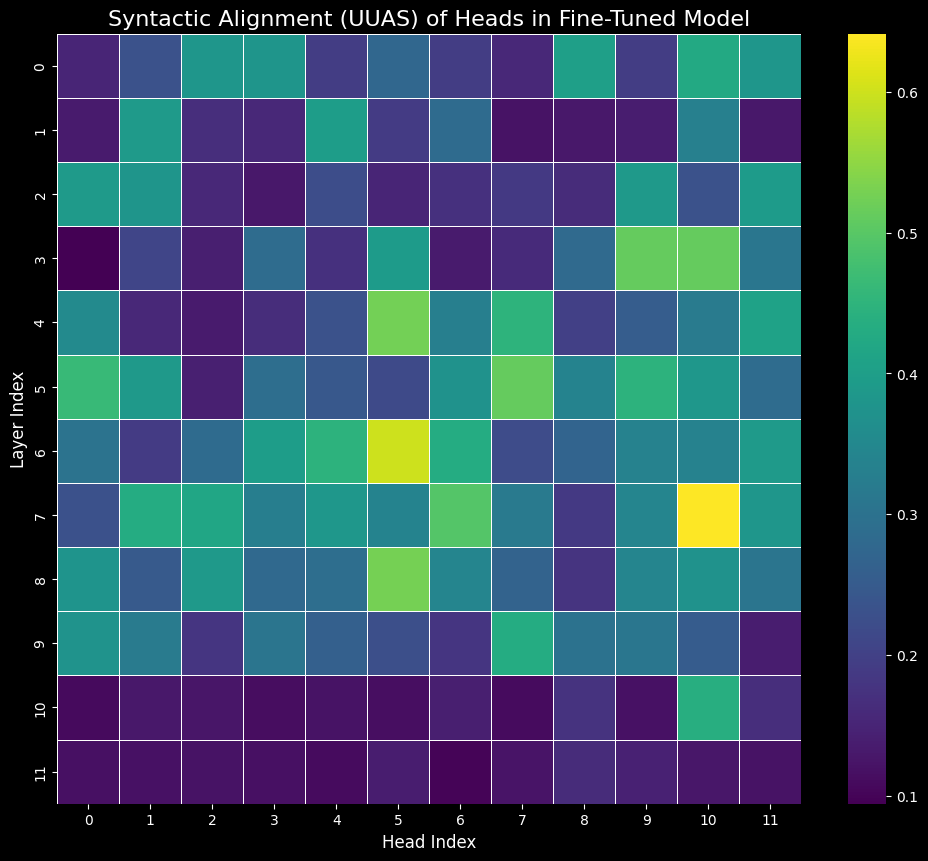


Saving fine-tuned UUAS scores to 'finetuned_bert_uuas_scores.csv'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Successfully downloaded finetuned_bert_uuas_scores.csv.

Phase 2 Comparative Analysis Complete.


In [ ]:

MODEL_NAME = './mnli_finetuned_model/final_best_model'

SAMPLE_SIZE = 9815

print("Initializing Stanza NLP pipeline...")
nlp_pipeline = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse', verbose=False)
print("Stanza pipeline ready.")

# The tokenizer for the fine-tuned model is the same as the original
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# We load the base BertModel from the fine-tuned path to get attention weights
model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"Model loaded from '{MODEL_NAME}' and moved to device: {device}")

dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"validation_matched[:{SAMPLE_SIZE}]")
print(f"Dataset loaded with {len(dataset)} sentences.")

# METRIC IMPLEMENTATION & ANALYSIS (Identical to pre-trained script)
print("\n" + "─" * 80)
print("IMPLEMENTING METRICS AND RUNNING ANALYSIS ON FINE-TUNED MODEL...")
print("─" * 80)

# --- Main Analysis Loop ---
head_scores = {
    (l, h): [] for l in range(model.config.num_hidden_layers) for h in range(model.config.num_attention_heads)
}

print("Starting analysis loop...")
for example in tqdm(dataset, desc="Analyzing Sentences"):
    sentence_text = example['premise']
    if not sentence_text: continue
    doc = nlp_pipeline(sentence_text)
    gold_dependencies = extract_gold_dependency_pairs_from_stanza(doc)
    token_to_word_map, tokens, original_words, encoding = create_offset_based_map(sentence_text, tokenizer, doc)

    model_inputs = {k: v.to(device) for k, v in encoding.items() if k != 'offset_mapping'}

    with torch.no_grad():
        outputs = model(**model_inputs)

    attentions = outputs.attentions

    for layer_idx in range(model.config.num_hidden_layers):
        for head_idx in range(model.config.num_attention_heads):
            attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()
            uuas, num_words = calculate_uuas_for_head(attention_matrix, token_to_word_map, gold_dependencies)
            if num_words > 0:
                head_scores[(layer_idx, head_idx)].append(uuas)

print("Analysis loop finished.")

# --- Aggregate, Visualize, and Save Results ---
results_data = []
for (layer, head), scores in head_scores.items():
    avg_score = np.mean(scores) if scores else 0
    results_data.append({"Layer": layer, "Head": head, "UUAS": avg_score})

results_df = pd.DataFrame(results_data)

print("\n" + "─" * 80)
print("Top 10 Most Syntactic Heads in FINE-TUNED Model (by Average UUAS)")
print("─" * 80)
print(results_df.sort_values(by="UUAS", ascending=False).head(10).to_string(index=False, float_format="%.4f"))

print("\n" + "─" * 80)
print("Generating UUAS Heatmap for FINE-TUNED Model...")
print("─" * 80)
plt.style.use('dark_background')
heatmap_data = results_df.pivot(index="Layer", columns="Head", values="UUAS")
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="viridis", linewidths=.5)
plt.title(f"Syntactic Alignment (UUAS) of Heads in Fine-Tuned Model", fontsize=16)
plt.xlabel("Head Index", fontsize=12)
plt.ylabel("Layer Index", fontsize=12)
plt.show()

# --- Save and Download the Results ---
output_filename = "finetuned_bert_uuas_scores.csv"
print(f"\nSaving fine-tuned UUAS scores to '{output_filename}'...")
results_df.to_csv(output_filename, index=False, float_format="%.4f")
files.download(output_filename)
print(f"Successfully downloaded {output_filename}.")

print("\nPhase 2 Comparative Analysis Complete.")


Successfully loaded and merged the final data.

Generating Plot 1: Tracking the Original Top 10 Syntactic Heads...


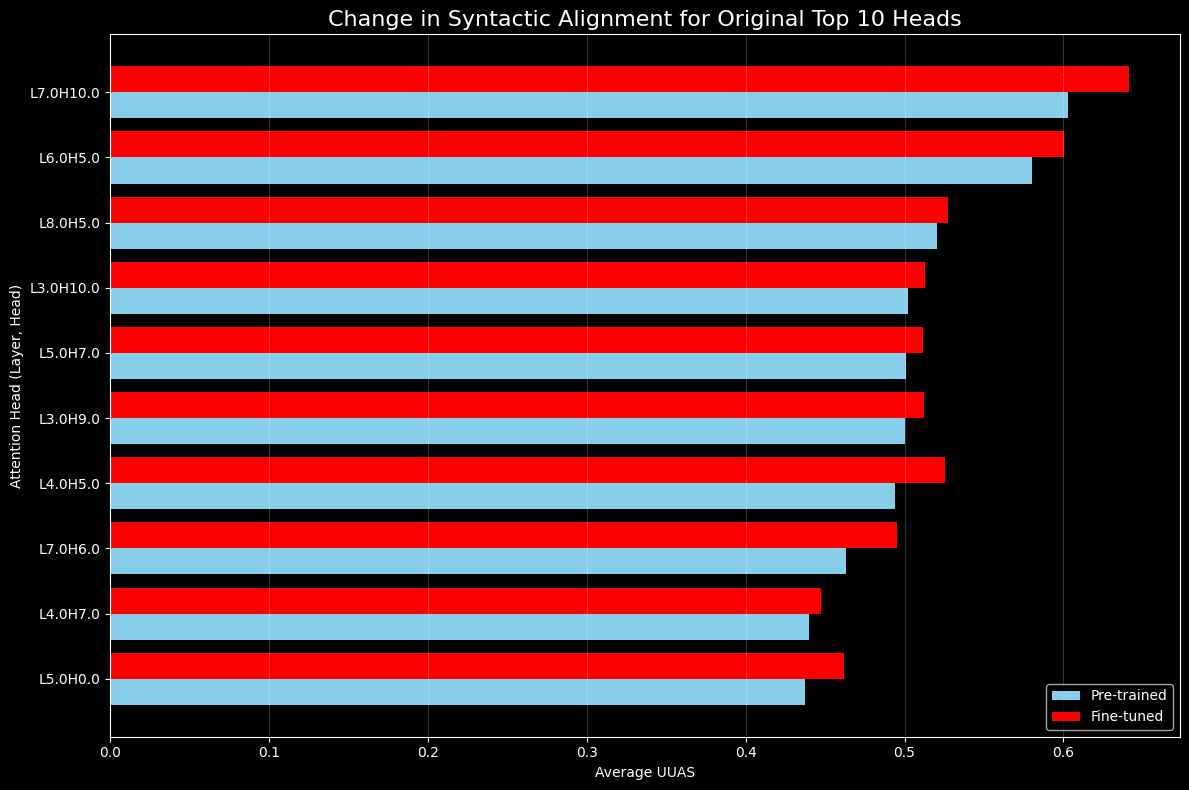


Generating Plot 2: Heatmap of UUAS Change (Delta)...


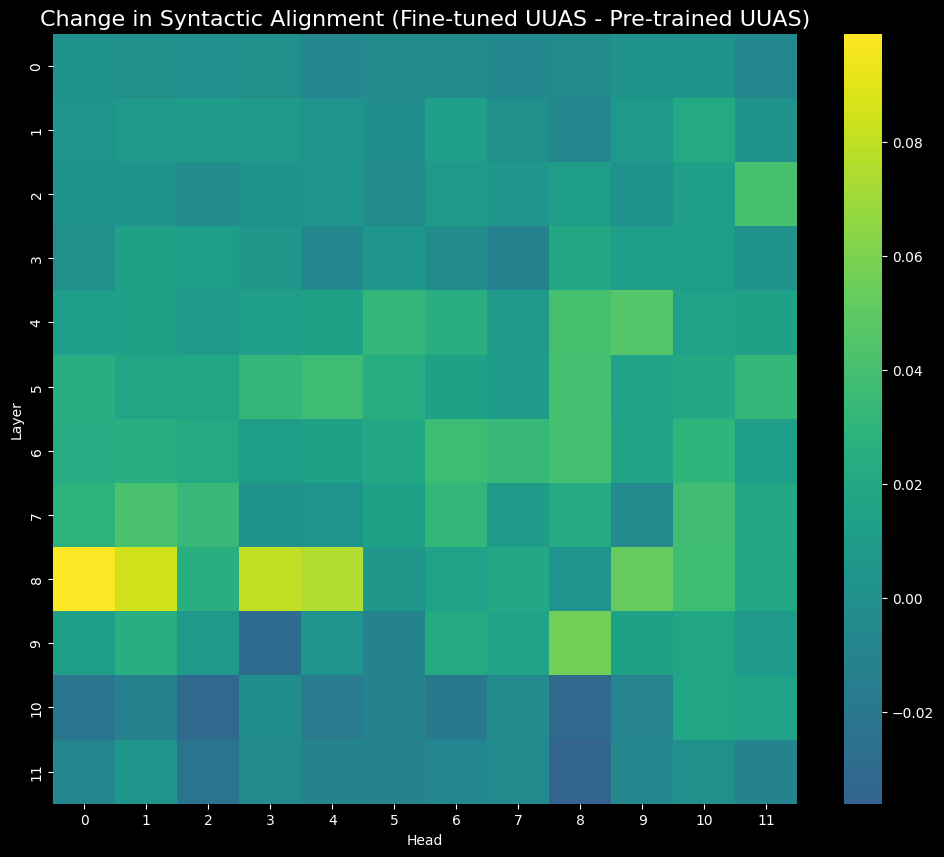


Generating Plot 3: Scatter Plot of Pre-trained vs. Fine-tuned Scores...


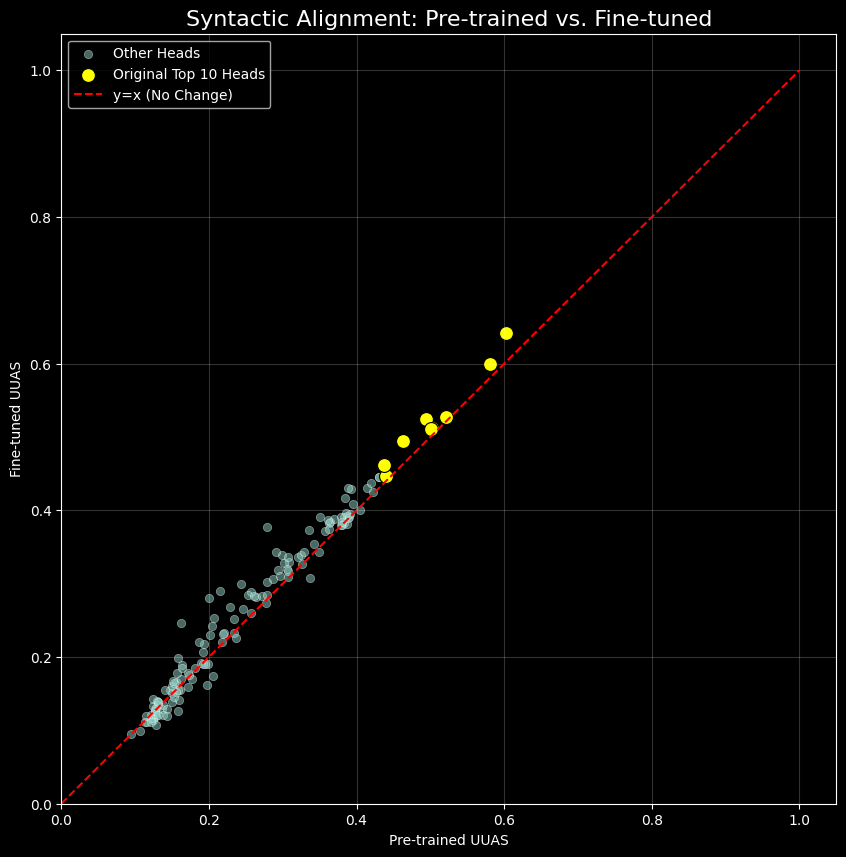


Generating Plot 4: Layer-wise Average UUAS...


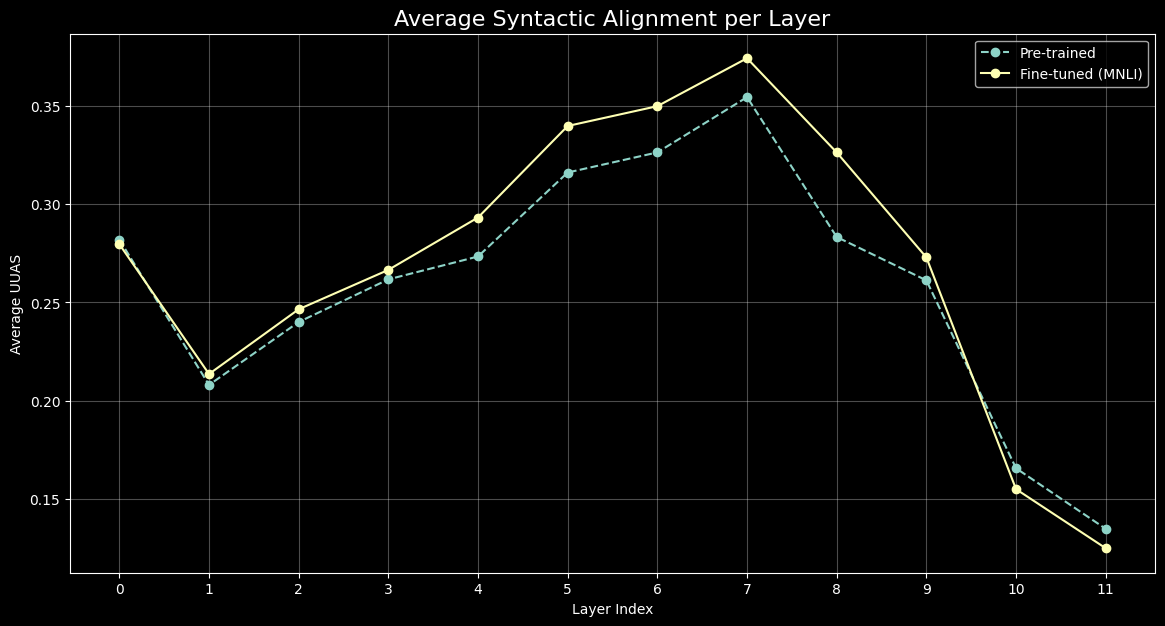

In [ ]:
# ==============================================================================
# SCRIPT: FINAL COMPARATIVE ANALYSIS AND VISUALIZATIONS
#
# DESCRIPTION:
# This script loads the FINAL UUAS scores and generates visualizations
# that highlight the key findings: intensification of syntactic roles and
# the stability of top-performing heads after fine-tuning.
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PRETRAINED_CSV_PATH = 'pretrained_bert_uuas_scores.csv'
FINETUNED_CSV_PATH = 'finetuned_bert_uuas_scores.csv'

try:
    df_pretrained = pd.read_csv(PRETRAINED_CSV_PATH)
    df_finetuned = pd.read_csv(FINETUNED_CSV_PATH)

    df_merged = pd.merge(
        df_pretrained.rename(columns={'UUAS': 'UUAS_Pretrained'}),
        df_finetuned.rename(columns={'UUAS': 'UUAS_Finetuned'}),
        on=['Layer', 'Head']
    )
    df_merged['UUAS_Change'] = df_merged['UUAS_Finetuned'] - df_merged['UUAS_Pretrained']
    print("Successfully loaded and merged the final data.")

except FileNotFoundError:
    print("ERROR: Make sure both 'pretrained_bert_uuas_scores.csv' and 'finetuned_bert_uuas_scores.csv' are uploaded.")
    df_merged = None


if df_merged is not None:
    # Visualization Generation
    plt.style.use('dark_background')

    # === PLOT 1: Tracking the Original Champions ===
    print("\nGenerating Plot 1: Tracking the Original Top 10 Syntactic Heads...")

    # Get the original top 10 heads
    original_top_10 = df_merged.sort_values(by='UUAS_Pretrained', ascending=False).head(10)
    original_top_10 = original_top_10.sort_values(by='UUAS_Pretrained', ascending=True) # Sort for plotting

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Create y-axis positions and labels
    y_pos = np.arange(len(original_top_10))
    head_labels = original_top_10.apply(lambda r: f'L{r.Layer}H{r.Head}', axis=1)

    # Plot the bars
    plt.barh(y_pos - 0.2, original_top_10['UUAS_Pretrained'], height=0.4, align='center', label='Pre-trained', color='skyblue')
    plt.barh(y_pos + 0.2, original_top_10['UUAS_Finetuned'], height=0.4, align='center', label='Fine-tuned', color='red')

    plt.yticks(y_pos, head_labels)
    plt.xlabel('Average UUAS')
    plt.ylabel('Attention Head (Layer, Head)')
    plt.title('Change in Syntactic Alignment for Original Top 10 Heads', fontsize=16)
    plt.legend()
    plt.grid(alpha=0.2, axis='x')
    plt.tight_layout()
    plt.show()

    # === PLOT 2: Heatmap of the Change (Delta UUAS) ===
    print("\nGenerating Plot 2: Heatmap of UUAS Change (Delta)...")
    plt.figure(figsize=(12, 10))
    heatmap_data_change = df_merged.pivot(index="Layer", columns="Head", values="UUAS_Change")
    # A diverging colormap shows positive (blue/green) and negative (red) changes clearly
    sns.heatmap(heatmap_data_change, cmap= "viridis", center=0)
    plt.title('Change in Syntactic Alignment (Fine-tuned UUAS - Pre-trained UUAS)', fontsize=16)
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.show()

    # === PLOT 3: Scatter Plot of Pre vs. Post Scores ===
    print("\nGenerating Plot 3: Scatter Plot of Pre-trained vs. Fine-tuned Scores...")
    plt.figure(figsize=(10, 10))

    # Highlight the original top 10 heads
    is_top_10 = df_merged.index.isin(original_top_10.index)

    sns.scatterplot(
        x='UUAS_Pretrained',
        y='UUAS_Finetuned',
        data=df_merged[~is_top_10],
        alpha=0.5,
        label='Other Heads'
    )
    sns.scatterplot(
        x='UUAS_Pretrained',
        y='UUAS_Finetuned',
        data=df_merged[is_top_10],
        color='yellow',
        s=100, # Make them larger
        edgecolor='black',
        label='Original Top 10 Heads'
    )

    # Add a y=x line to show improvement vs. degradation
    plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='y=x (No Change)')

    plt.title('Syntactic Alignment: Pre-trained vs. Fine-tuned', fontsize=16)
    plt.xlabel('Pre-trained UUAS')
    plt.ylabel('Fine-tuned UUAS')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()

    # === PLOT 4: Layer-wise Average UUAS ===
    print("\nGenerating Plot 4: Layer-wise Average UUAS...")
    layer_avg = df_merged.groupby('Layer')[['UUAS_Pretrained', 'UUAS_Finetuned']].mean().reset_index()

    plt.figure(figsize=(14, 7))
    plt.plot(layer_avg['Layer'], layer_avg['UUAS_Pretrained'], marker='o', linestyle='--', label='Pre-trained')
    plt.plot(layer_avg['Layer'], layer_avg['UUAS_Finetuned'], marker='o', linestyle='-', label='Fine-tuned (MNLI)')

    plt.title('Average Syntactic Alignment per Layer', fontsize=16)
    plt.xlabel('Layer Index')
    plt.ylabel('Average UUAS')
    plt.xticks(np.arange(0, 12, 1))
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


In [8]:
# =============================================================================
# PHASE 3: HEAD IMPORTANCE AND PRUNING (FASTER EVALUATION)
# =============================================================================

print("─" * 80)
print("PHASE 3: HEAD IMPORTANCE AND PRUNING...")
print("─" * 80)

# --- 1. Environment Setup & Imports ---
print("Installing and importing libraries...")

# Install necessary libraries
import subprocess
import sys

def install(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

try:
    install("transformers")
    install("datasets")
    install("accelerate")
    install("evaluate")
    install("stanza") # <-- Installing stanza
    install("numpy")
    install("pandas")
except Exception as e:
    print(f"An error occurred during installation: {e}")

# Now import them
import torch
import numpy as np
import pandas as pd
import stanza # <-- This will now work
import evaluate
import os
import copy
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertModel,
    BertTokenizerFast,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from google.colab import drive

# Download the Stanza model (needed for the helper functions)
print("\nDownloading Stanza English model...")
try:
    stanza.download('en', verbose=False) # <-- Also added this download step
    print("Stanza model downloaded successfully!")
except Exception as e:
    print(f"An error occurred during Stanza model download: {e}")


# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 2. Mount Drive and Define Paths ---
print("\nMounting Google Drive...")
try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Drive already mounted or error: {e}")

# --- !! IMPORTANT !! ---
# This is the path to your fine-tuned model on Google Drive
MODEL_PATH = "/content/drive/My Drive/AttentionHeads/finetuned_bert_mnli"

# This is the CSV file generated by the end of your previous notebook
# *** YOU MUST UPLOAD THIS FILE TO YOUR COLAB SESSION ***
UUAS_SCORES_PATH = "finetuned_bert_uuas_scores.csv"

if not os.path.exists(UUAS_SCORES_PATH):
    print("="*80)
    print(f"ERROR: File not found: '{UUAS_SCORES_PATH}'")
    print("Please upload this file from your previous notebook run to continue.")
    print("="*80)
    # Stop execution if the file is missing
    raise FileNotFoundError(f"{UUAS_SCORES_PATH} not found. Please upload it.")

# --- 3. Load Models, Data, and Pipelines ---
print("\nLoading models, data, and pipelines...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the full model (with classification head) for task evaluation
model_for_task = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
model_for_task.eval()

# Load the base BertModel (for attention access) for syntax evaluation
model_for_syntax = BertModel.from_pretrained(MODEL_PATH, output_attentions=True).to(device)
model_for_syntax.eval()

# Load the tokenizer (same for both)
tokenizer = BertTokenizerFast.from_pretrained(MODEL_PATH)

# Load Stanza pipeline for UUAS
print("Initializing Stanza NLP pipeline...")
nlp_pipeline = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse', verbose=False)
print("Stanza pipeline ready.")

# Load datasets
DATASET_NAME = 'glue'
DATASET_CONFIG = 'mnli'
TASK_EVAL_SAMPLE_SIZE = 1000  # Sample size for quick task evaluation

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!  MODIFICATION: Using a smaller sample for PRUNING_EVAL  !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
SYNTAX_PRUNING_EVAL_SAMPLE_SIZE = 1000 # Was 9815, now 1000 for speed

full_val_dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"validation_matched")

# Dataset for MNLI accuracy evaluation
mnli_val_task = full_val_dataset.shuffle(seed=42).select(range(TASK_EVAL_SAMPLE_SIZE))

# Dataset for UUAS syntax evaluation (using premise only)
# We now use the smaller sample size for this.
mnli_val_syntax_pruning = full_val_dataset.shuffle(seed=43).select(range(SYNTAX_PRUNING_EVAL_SAMPLE_SIZE))

print(f"Loaded {len(mnli_val_task)} samples for task eval.")
print(f"Loaded {len(mnli_val_syntax_pruning)} samples for PRUNING syntax eval (was 9815).")


# Store a clean copy of the original model weights
original_task_state_dict = copy.deepcopy(model_for_task.state_dict())
original_syntax_state_dict = copy.deepcopy(model_for_syntax.state_dict())

# --- 4. Helper Functions (Copied from your notebook + new ones) ---
print("\nDefining helper functions...")

# --- Functions from your notebook (for UUAS) ---
def create_offset_based_map(sentence_text, tokenizer, stanza_doc):
    stanza_word_offsets = []
    original_words = []
    for sentence in stanza_doc.sentences:
        for word in sentence.words:
            original_words.append(word.text)
            stanza_word_offsets.append((word.start_char, word.end_char))

    encoding = tokenizer(sentence_text, return_offsets_mapping=True, return_tensors="pt")
    bert_token_offsets = encoding['offset_mapping'][0]

    token_to_word_map = []
    for token_start, token_end in bert_token_offsets:
        if token_start == 0 and token_end == 0:
            token_to_word_map.append(-1)
            continue
        found = False
        for word_idx, (word_start, word_end) in enumerate(stanza_word_offsets):
            if token_start >= word_start and token_end <= word_end:
                token_to_word_map.append(word_idx)
                found = True
                break
        if not found:
            token_to_word_map.append(-1)

    tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    return token_to_word_map, tokens, original_words, encoding

def extract_gold_dependency_pairs_from_stanza(doc):
    gold_pairs = set()
    offset = 0
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.head > 0:
                head_index = word.head - 1 + offset
                dependent_index = word.id - 1 + offset
                gold_pairs.add(tuple(sorted((head_index, dependent_index))))
        offset += len(sentence.words)
    return gold_pairs

def calculate_uuas_for_head(attention_matrix, token_to_word_map, gold_pairs):
    if not gold_pairs:
        return 0.0, 0
    correct_predictions = 0
    total_words = 0
    num_tokens = len(token_to_word_map)
    word_indices = sorted(list(set(idx for idx in token_to_word_map if idx != -1)))

    for word_idx in word_indices:
        total_words += 1
        source_token_indices = [i for i, w_idx in enumerate(token_to_word_map) if w_idx == word_idx]
        aggregated_attention = attention_matrix[source_token_indices, :].mean(axis=0)
        valid_targets_mask = np.array([1 if token_to_word_map[i] not in [-1, word_idx] else 0 for i in range(num_tokens)])
        if np.sum(valid_targets_mask) == 0:
            continue
        max_attention_idx = np.argmax(aggregated_attention * valid_targets_mask)
        predicted_head_word_idx = token_to_word_map[max_attention_idx]
        predicted_pair = tuple(sorted((word_idx, predicted_head_word_idx)))
        if predicted_pair in gold_pairs:
            correct_predictions += 1
    uuas = correct_predictions / total_words if total_words > 0 else 0.0
    return uuas, total_words

# --- Functions from your notebook (for Task Eval) ---
def tokenize_function(examples, tokenizer):
    """Tokenizes the premise and hypothesis text for the NLI task."""
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def compute_metrics(eval_pred):
    """Computes accuracy during evaluation."""
    metric = evaluate.load("glue", DATASET_CONFIG)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# --- NEW Helper Function: Pruning ---
def prune_head_weights(model, layer_idx, head_idx):
    """Sets the weights of a specific attention head to zero."""

    # Determine if we're pruning BertModel or BertForSequenceClassification
    if hasattr(model, 'bert'):
        bert_model = model.bert
    else:
        bert_model = model

    config = bert_model.config
    head_size = config.hidden_size // config.num_attention_heads
    start = head_idx * head_size
    end = (head_idx + 1) * head_size

    attention_module = bert_model.encoder.layer[layer_idx].attention

    with torch.no_grad():
        # Prune self-attention Q, K, V weights and biases
        attention_module.self.query.weight.data[:, start:end].zero_()
        attention_module.self.query.bias.data[start:end].zero_()
        attention_module.self.key.weight.data[:, start:end].zero_()
        attention_module.self.key.bias.data[start:end].zero_()
        attention_module.self.value.weight.data[:, start:end].zero_()
        attention_module.self.value.bias.data[start:end].zero_()

        # Prune the corresponding input weights of the output dense layer
        attention_module.output.dense.weight.data[:, start:end].zero_()
        # We don't prune the output bias, as it's shared by all heads' outputs

# --- NEW Helper Function: Task Evaluation ---
def evaluate_mnli_accuracy(model, dataset, tokenizer):
    """Evaluates the model's accuracy on the MNLI validation set."""

    # Tokenize the dataset
    tokenized_dataset = dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True,
        desc="Tokenizing for Task Eval"
    )
    tokenized_dataset.set_format(
        type='torch',
        columns=['input_ids', 'token_type_ids', 'attention_mask', 'label']
    )

    # Set up a minimal Trainer for evaluation
    training_args = TrainingArguments(
        output_dir="./eval_temp",
        per_device_eval_batch_size=32,
        report_to="none"  # Disable logging to wandb/etc.
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=tokenized_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    # Run evaluation
    eval_results = trainer.evaluate()
    return eval_results['eval_accuracy']

# --- NEW Helper Function: Syntax Evaluation (Full) ---
def run_full_uuas_analysis(model, dataset, tokenizer, nlp_pipeline):
    """Runs the full UUAS analysis loop from the notebook on a given model."""

    model.eval()
    head_scores = {
        (l, h): []
        for l in range(model.config.num_hidden_layers)
        for h in range(model.config.num_attention_heads)
    }

    # !! MODIFICATION: Using smaller dataset for this analysis !!
    desc = f"Running UUAS Analysis on {len(dataset)} samples"
    for example in tqdm(dataset, desc=desc):
        sentence_text = example['premise']
        if not sentence_text: continue

        doc = nlp_pipeline(sentence_text)
        gold_dependencies = extract_gold_dependency_pairs_from_stanza(doc)
        token_to_word_map, tokens, original_words, encoding = create_offset_based_map(sentence_text, tokenizer, doc)

        model_inputs = {k: v.to(device) for k, v in encoding.items() if k != 'offset_mapping'}

        with torch.no_grad():
            outputs = model(**model_inputs)

        attentions = outputs.attentions

        for layer_idx in range(model.config.num_hidden_layers):
            for head_idx in range(model.config.num_attention_heads):
                attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()
                uuas, num_words = calculate_uuas_for_head(attention_matrix, token_to_word_map, gold_dependencies)
                if num_words > 0:
                    head_scores[(layer_idx, head_idx)].append(uuas)

    # Aggregate results
    results_data = []
    for (layer, head), scores in head_scores.items():
        avg_score = np.mean(scores) if scores else 0
        results_data.append({"Layer": layer, "Head": head, "UUAS": avg_score})

    return pd.DataFrame(results_data)

print("All helper functions defined.")

────────────────────────────────────────────────────────────────────────────────
PHASE 3: HEAD IMPORTANCE AND PRUNING...
────────────────────────────────────────────────────────────────────────────────
Installing and importing libraries...
Installing transformers...
Installing datasets...
Installing accelerate...
Installing evaluate...
Installing stanza...
Installing numpy...
Installing pandas...

Stanza model downloaded successfully!

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Loading models, data, and pipelines...
Initializing Stanza NLP pipeline...
Stanza pipeline ready.
Loaded 1000 samples for task eval.
Loaded 1000 samples for PRUNING syntax eval (was 9815).

Defining helper functions...
All helper functions defined.


In [9]:
# =============================================================================
# STEP 1: GET BASELINE PERFORMANCE (BEFORE PRUNING)
# =============================================================================
print("─" * 80)
print("STEP 1: Calculating Baseline Performance...")
print("─" * 80)

# 1. Baseline Task Accuracy
baseline_accuracy = evaluate_mnli_accuracy(model_for_task, mnli_val_task, tokenizer)
print(f"Baseline MNLI Accuracy (on {TASK_EVAL_SAMPLE_SIZE} samples): {baseline_accuracy:.4f}")

# 2. Baseline Syntactic Alignment
df_syntax_scores = pd.read_csv(UUAS_SCORES_PATH)
baseline_avg_uuas = df_syntax_scores['UUAS'].mean()
print(f"Baseline Average UUAS (from {UUAS_SCORES_PATH}): {baseline_avg_uuas:.4f}")

────────────────────────────────────────────────────────────────────────────────
STEP 1: Calculating Baseline Performance...
────────────────────────────────────────────────────────────────────────────────


Tokenizing for Task Eval:   0%|          | 0/1000 [00:00<?, ? examples/s]

Baseline MNLI Accuracy (on 1000 samples): 0.7190
Baseline Average UUAS (from finetuned_bert_uuas_scores.csv): 0.2702


In [5]:
# =============================================================================
# STEP 2: RANK HEADS BY TASK PERFORMANCE (ABLATION)
# =============================================================================
print("─" * 80)
print("STEP 2: Ranking heads by task performance (Ablation)...")
print("This will take a while (evaluating the model 144 times).")
print("─" * 80)

head_importance_scores = []
num_layers = model_for_task.config.num_hidden_layers
num_heads = model_for_task.config.num_attention_heads

pbar = tqdm(total=num_layers * num_heads, desc="Ablating Heads")

for l in range(num_layers):
    for h in range(num_heads):
        # 1. Restore the model to its original state
        model_for_task.load_state_dict(original_task_state_dict)

        # 2. Prune the specific head
        prune_head_weights(model_for_task, l, h)

        # 3. Evaluate the pruned model
        pruned_accuracy = evaluate_mnli_accuracy(model_for_task, mnli_val_task, tokenizer)

        # 4. Calculate importance (drop in accuracy)
        importance = baseline_accuracy - pruned_accuracy
        head_importance_scores.append({'layer': l, 'head': h, 'importance': importance})
        pbar.update(1)

pbar.close()

# Create and display the task importance dataframe
df_task_importance = pd.DataFrame(head_importance_scores).sort_values(by='importance', ascending=False)
print("\n--- Top 10 Most Important Heads for MNLI Task (by Accuracy Drop) ---")
print(df_task_importance.head(10).to_string(index=False, float_format="%.4f"))

print("\n--- Top 10 Least Important Heads for MNLI Task (by Accuracy Drop) ---")
print(df_task_importance.tail(10).to_string(index=False, float_format="%.4f"))

────────────────────────────────────────────────────────────────────────────────
STEP 2: Ranking heads by task performance (Ablation)...
This will take a while (evaluating the model 144 times).
────────────────────────────────────────────────────────────────────────────────


Ablating Heads:   0%|          | 0/144 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- Top 10 Most Important Heads for MNLI Task (by Accuracy Drop) ---
 layer  head  importance
     6     5      0.0070
    10    11      0.0030
     9     6      0.0020
    10    10      0.0020
     9     8      0.0020
     8     5      0.0020
    11     1      0.0020
     8     3      0.0020
     4     6      0.0020
     9    10      0.0020

--- Top 10 Least Important Heads for MNLI Task (by Accuracy Drop) ---
 layer  head  importance
     5     7     -0.0120
     4     5     -0.0120
     7     5     -0.0120
     5     3     -0.0120
     5     9     -0.0130
     4     4     -0.0130
     0     7     -0.0140
     3     9     -0.0140
     5    10     -0.0140
     5    11     -0.0170


In [6]:
# =============================================================================
# STEP 3: RANK HEADS BY SYNTAX (UUAS)
# =============================================================================
print("─" * 80)
print("STEP 3: Ranking heads by syntactic alignment (UUAS)...")
print("─" * 80)

# This was already calculated and loaded from the CSV
df_syntax_importance = df_syntax_scores.sort_values(by='UUAS', ascending=False)

print("--- Top 10 Most Syntactic Heads (by UUAS) ---")
print(df_syntax_importance.head(10).to_string(index=False, float_format="%.4f"))

────────────────────────────────────────────────────────────────────────────────
STEP 3: Ranking heads by syntactic alignment (UUAS)...
────────────────────────────────────────────────────────────────────────────────
--- Top 10 Most Syntactic Heads (by UUAS) ---
 Layer  Head   UUAS
     7    10 0.6413
     6     5 0.6003
     8     5 0.5275
     4     5 0.5253
     3    10 0.5128
     3     9 0.5120
     5     7 0.5114
     7     6 0.4953
     5     0 0.4621
     4     7 0.4474


In [10]:
# =============================================================================
# STEP 4: PRUNING EXPERIMENT 1 (PRUNE LEAST IMPORTANT FOR TASK)
# =============================================================================
print("─" * 80)
print("STEP 4: Pruning bottom 25% (36) of heads by TASK performance...")
print("─" * 80)

# 1. Get the 36 heads to prune (bottom 25% by task importance)
num_layers = model_for_task.config.num_hidden_layers
num_heads = model_for_task.config.num_attention_heads
N_TO_PRUNE = int(num_layers * num_heads * 0.25)
heads_to_prune_task = df_task_importance.tail(N_TO_PRUNE)


# 2. Restore models to their original clean state
model_for_task.load_state_dict(original_task_state_dict)
model_for_syntax.load_state_dict(original_syntax_state_dict)

# 3. Apply the pruning permanently to both models
print(f"Pruning {len(heads_to_prune_task)} heads...")
for _, row in heads_to_prune_task.iterrows():
    l, h = int(row['layer']), int(row['head'])
    prune_head_weights(model_for_task, l, h)
    prune_head_weights(model_for_syntax, l, h)
print("Pruning complete.")

# 4. Evaluate the pruned model
print(f"Evaluating pruned model (Task Performance on {TASK_EVAL_SAMPLE_SIZE} samples)...")
task_pruned_accuracy = evaluate_mnli_accuracy(model_for_task, mnli_val_task, tokenizer)

print(f"Evaluating pruned model (Syntactic Alignment on {SYNTAX_PRUNING_EVAL_SAMPLE_SIZE} samples)...")
task_pruned_uuas_df = run_full_uuas_analysis(model_for_syntax, mnli_val_syntax_pruning, tokenizer, nlp_pipeline)
task_pruned_avg_uuas = task_pruned_uuas_df['UUAS'].mean()

# 5. Report Results
print("\n" + "─" * 80)
print("--- RESULTS: Pruning by TASK (Bottom 25%) ---")
print(f"Baseline MNLI Accuracy (on {TASK_EVAL_SAMPLE_SIZE} samples): {baseline_accuracy:.4f}")
print(f"New MNLI Accuracy (on {TASK_EVAL_SAMPLE_SIZE} samples):      {task_pruned_accuracy:.4f}")
print(f"Change in Accuracy:                                {task_pruned_accuracy - baseline_accuracy:+.4f}")
print("\n")
print(f"Baseline Average UUAS (from CSV, 9815 samples):    {baseline_avg_uuas:.4f}")
print(f"New Average UUAS (on {SYNTAX_PRUNING_EVAL_SAMPLE_SIZE} samples):       {task_pruned_avg_uuas:.4f}")
print(f"Change in UUAS:                                    {task_pruned_avg_uuas - baseline_avg_uuas:+.4f}")
print("─" * 80)

────────────────────────────────────────────────────────────────────────────────
STEP 4: Pruning bottom 25% (36) of heads by TASK performance...
────────────────────────────────────────────────────────────────────────────────
Pruning 36 heads...
Pruning complete.
Evaluating pruned model (Task Performance on 1000 samples)...


Tokenizing for Task Eval:   0%|          | 0/1000 [00:00<?, ? examples/s]

Evaluating pruned model (Syntactic Alignment on 1000 samples)...


Running UUAS Analysis on 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
--- RESULTS: Pruning by TASK (Bottom 25%) ---
Baseline MNLI Accuracy (on 1000 samples): 0.7190
New MNLI Accuracy (on 1000 samples):      0.6200
Change in Accuracy:                                -0.0990


Baseline Average UUAS (from CSV, 9815 samples):    0.2702
New Average UUAS (on 1000 samples):       0.2414
Change in UUAS:                                    -0.0288
────────────────────────────────────────────────────────────────────────────────


In [11]:
# =============================================================================
# STEP 5: PRUNING EXPERIMENT 2 (PRUNE MOST SYNTACTIC)
# =============================================================================
print("─" * 80)
print("STEP 5: Pruning top 25% (36) of heads by SYNTAX (UUAS)...")
print("─" * 80)

# 1. Get the 36 heads to prune (top 25% by UUAS)
N_TO_PRUNE = int(num_layers * num_heads * 0.25)
heads_to_prune_syntax = df_syntax_importance.head(N_TO_PRUNE)

# 2. Restore models to their original clean state
model_for_task.load_state_dict(original_task_state_dict)
model_for_syntax.load_state_dict(original_syntax_state_dict)

# 3. Apply the pruning permanently to both models
print(f"Pruning {len(heads_to_prune_syntax)} heads...")
for _, row in heads_to_prune_syntax.iterrows():
    l, h = int(row['Layer']), int(row['Head']) # Note: Column names from CSV are capitalized
    prune_head_weights(model_for_task, l, h)
    prune_head_weights(model_for_syntax, l, h)
print("Pruning complete.")

# 4. Evaluate the pruned model
print(f"Evaluating pruned model (Task Performance on {TASK_EVAL_SAMPLE_SIZE} samples)...")
syntax_pruned_accuracy = evaluate_mnli_accuracy(model_for_task, mnli_val_task, tokenizer)

print(f"Evaluating pruned model (Syntactic Alignment on {SYNTAX_PRUNING_EVAL_SAMPLE_SIZE} samples)...")
syntax_pruned_uuas_df = run_full_uuas_analysis(model_for_syntax, mnli_val_syntax_pruning, tokenizer, nlp_pipeline)
syntax_pruned_avg_uuas = syntax_pruned_uuas_df['UUAS'].mean()

# 5. Report Results
print("\n" + "─" * 80)
print("--- RESULTS: Pruning by SYNTAX (Top 25%) ---")
print(f"Baseline MNLI Accuracy (on {TASK_EVAL_SAMPLE_SIZE} samples): {baseline_accuracy:.4f}")
print(f"New MNLI Accuracy (on {TASK_EVAL_SAMPLE_SIZE} samples):      {syntax_pruned_accuracy:.4f}")
print(f"Change in Accuracy:                                {syntax_pruned_accuracy - baseline_accuracy:+.4f}")
print("\n")
print(f"Baseline Average UUAS (from CSV, 9815 samples):    {baseline_avg_uuas:.4f}")
print(f"New Average UUAS (on {SYNTAX_PRUNING_EVAL_SAMPLE_SIZE} samples):       {syntax_pruned_avg_uuas:.4f}")
print(f"Change in UUAS:                                    {syntax_pruned_avg_uuas - baseline_avg_uuas:+.4f}")
print("─" * 80)

────────────────────────────────────────────────────────────────────────────────
STEP 5: Pruning top 25% (36) of heads by SYNTAX (UUAS)...
────────────────────────────────────────────────────────────────────────────────
Pruning 36 heads...
Pruning complete.
Evaluating pruned model (Task Performance on 1000 samples)...


Tokenizing for Task Eval:   0%|          | 0/1000 [00:00<?, ? examples/s]

Evaluating pruned model (Syntactic Alignment on 1000 samples)...


Running UUAS Analysis on 1000 samples:   0%|          | 0/1000 [00:00<?, ?it/s]


────────────────────────────────────────────────────────────────────────────────
--- RESULTS: Pruning by SYNTAX (Top 25%) ---
Baseline MNLI Accuracy (on 1000 samples): 0.7190
New MNLI Accuracy (on 1000 samples):      0.5800
Change in Accuracy:                                -0.1390


Baseline Average UUAS (from CSV, 9815 samples):    0.2702
New Average UUAS (on 1000 samples):       0.2359
Change in UUAS:                                    -0.0343
────────────────────────────────────────────────────────────────────────────────
